In [1]:

import cv2
import pandas as pd
import numpy as np
import os
import glob
import torch
import torch.nn as nn
from torchvision.utils import make_grid
from collections import OrderedDict
from PIL import Image
import matplotlib.pyplot as plt
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
from torchvision import transforms, models
from torchvision.models import resnet50, ResNet50_Weights
from torch.utils.data import Dataset, DataLoader
import PIL
from PIL import Image
import tensorflow as tf
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing.image import save_img
import sklearn as sk
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, balanced_accuracy_score, confusion_matrix, f1_score
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)


2024-04-08 07:31:46.759919: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-08 07:31:47.443259: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
#Local

train_truth_local = '/home/teb344/Desktop/Oladayo_FIles/Machine Learning Project/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv'
validation_truth_local = '/home/teb344/Desktop/Oladayo_FIles/Machine Learning Project/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv'

train_img_dir_local = '/home/teb344/Desktop/Oladayo_FIles/Machine Learning Project/ISIC2018_Task3_Training_Input/ISIC2018_Task3_Training_Input'

test_truth_local = '/home/teb344/Desktop/Oladayo_FIles/Machine Learning Project/Testing/ISIC2018_Task3_Test_GroundTruth/ISIC2018_Task3_Test_GroundTruth.csv'
test_img_dir_local = '/home/teb344/Desktop/Oladayo_FIles/Machine Learning Project/Testing/ISIC2018_Task3_Test_Input'


In [3]:
train_df = pd.read_csv(train_truth_local)
classes = train_df.columns[1:]
train_df['label'] = train_df.iloc[:, 1:].idxmax(axis=1)

validation_df = pd.read_csv(validation_truth_local)
validation_df['label'] = validation_df.iloc[:, 1:].idxmax(axis=1)

train_image_directory = train_img_dir_local
testing_img_directory = test_img_dir_local

In [4]:
label_to_idx = {label: idx for idx, label in enumerate(train_df.iloc[:, 1:].columns)}
train_df['label_idx'] = train_df['label'].map(label_to_idx)
train_df.tail()

,image,MEL,NV,BCC,AKIEC,BKL,DF,VASC,label,label_idx
10010,ISIC_0034316,1.0,0.0,0.0,0.0,0.0,0.0,0.0,MEL,0
10011,ISIC_0034317,1.0,0.0,0.0,0.0,0.0,0.0,0.0,MEL,0
10012,ISIC_0034318,0.0,0.0,0.0,0.0,1.0,0.0,0.0,BKL,4
10013,ISIC_0034319,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NV,1
10014,ISIC_0034320,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NV,1


In [5]:
testing_df = pd.read_csv(test_truth_local)
testing_df['label'] = testing_df.iloc[:, 1:].idxmax(axis=1)

label_to_idx = {label: idx for idx, label in enumerate(testing_df.iloc[:, 1:].columns)}
testing_df['label_idx'] = testing_df['label'].map(label_to_idx)
testing_df.head()

,image,MEL,NV,BCC,AKIEC,BKL,DF,VASC,label,label_idx
0,ISIC_0034524,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NV,1
1,ISIC_0034525,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NV,1
2,ISIC_0034526,0.0,0.0,0.0,0.0,1.0,0.0,0.0,BKL,4
3,ISIC_0034527,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NV,1
4,ISIC_0034528,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NV,1


In [6]:
label_to_idx = {label: idx for idx, label in enumerate(validation_df.iloc[:, 1:].columns)}
validation_df['label_idx'] = validation_df['label'].map(label_to_idx)
validation_df.head()

,image,MEL,NV,BCC,AKIEC,BKL,DF,VASC,label,label_idx
0,ISIC_0034321,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NV,1
1,ISIC_0034322,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NV,1
2,ISIC_0034323,0.0,0.0,1.0,0.0,0.0,0.0,0.0,BCC,2
3,ISIC_0034324,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NV,1
4,ISIC_0034325,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NV,1


In [7]:
# Merging both training and validation dataframes 
train_all = pd.concat([train_df, validation_df], ignore_index=True)
train_df = train_all

In [8]:
def plot_data(data):
    # Display 5 images from each class
    for class_name in classes:
        # Filter the DataFrame to get 5 image names for the current class
        class_images = data[data[class_name] == 1.0]['image'].values[:5]
        # Create a subplot for each class
        fig, axs = plt.subplots(1, 5, figsize=(20, 4))
        fig.suptitle(class_name)
        image_sizes = []
        for i, image_name in enumerate(class_images):
            image_path = os.path.join(train_image_directory, image_name + '.jpg')
            image = Image.open(image_path)
            axs[i].imshow(image)
            axs[i].axis('off')  # Hide the axis
            axs[i].set_title(f'{image_name}\n{image.size}')

        plt.show()
# uncomment plot_data(train_df)

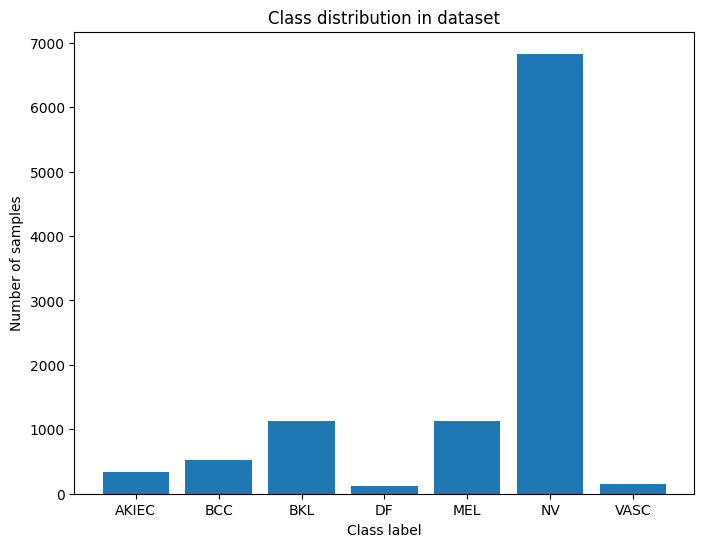

In [9]:
# uncomment check Class distribution in dataset
unique_labels, counts = np.unique(train_df['label'], return_counts=True)
plt.figure(figsize=(8, 6))
plt.bar(unique_labels, counts)
plt.xlabel('Class label')
plt.ylabel('Number of samples')
plt.title('Class distribution in dataset')
plt.show()

In [10]:
train_df['label_idx'].value_counts()
cols = {
    1 : "NV",
    0 : "MEL",
    4 : "BKL",
    2 : "BCC",
    3 : "AKIEC",
    6 : "VASC",
    5 : "DF"

}

In [11]:
# Function for the image genration
datagen = ImageDataGenerator(
    rotation_range=20,
    height_shift_range=0.1,
    # shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
    )


In [12]:
def sharpenImage(image):

    # Split image channels
    b, g, r = cv2.split(image)

    # Black hat transformation
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (15, 15))
    blackhatB = cv2.morphologyEx(b, cv2.MORPH_BLACKHAT, kernel)
    blackhatG = cv2.morphologyEx(g, cv2.MORPH_BLACKHAT, kernel)
    blackhatR = cv2.morphologyEx(r, cv2.MORPH_BLACKHAT, kernel)

    # Merge the channels
    blackhat = cv2.merge([blackhatB, blackhatG, blackhatR])

    # Sharpen the image
    sharpened = np.clip(image.astype(np.int16)- blackhat.astype(np.int16), 0, 255).astype(np.uint8)
    sharpened = cv2.cvtColor(sharpened, cv2.COLOR_BGR2RGB)
    # sharpened = torch.tensor(sharpened, dtype=torch.float32)


    return sharpened
images = train_df['image'].values[3429:3434]


In [13]:
# Hair Removal
def remove_hair(image):
    # Converting to numpy from PIL
    image = np.array(image)

    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Enhance image
    Kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (15, 15))
    blackhat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, Kernel)
    enhanced = np.clip(gray.astype(np.int16) - blackhat.astype(np.int16), 0, 255).astype(np.uint8)

    # Canney edge detect enhanced image
    edges = cv2.Canny(enhanced, 150, 1750)

    # Dilate detected edges
    kernel = np.ones((5, 5), np.uint8)
    edges = cv2.dilate(edges, kernel, iterations=1)

    # Canney edge detect enhanced image
    edges2 = cv2.Canny(enhanced, 225, 325)

    # Dilate detected edges
    edges2 = cv2.dilate(edges2, kernel, iterations=1)

    # Find contours in the edge detected dilated image
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    # Iterate through each contour in the first
    for i, contour in enumerate(contours):
        epsilon = 1.2
        approx = cv2.approxPolyDP(contour, epsilon, True)
        perimeter = cv2.arcLength(contour, closed=True)
        area = cv2.contourArea(contour)
        threshold = 1.1

        if ((len(approx)*(3+np.log(area)))/(perimeter) >= threshold) or (area < 300):
            edges = cv2.drawContours(edges, [contour], -1, 0, thickness=cv2.FILLED)

    # Find contours in the edge detected dilated image
    contours2, _ = cv2.findContours(edges2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    # Iterate through each contour in the second
    for i, contour in enumerate(contours2):
        epsilon = 1.2
        approx = cv2.approxPolyDP(contour, epsilon, True)
        perimeter = cv2.arcLength(contour, closed=True)
        area = cv2.contourArea(contour)
        threshold = 0.9

        if ((len(approx)*(3+np.log(area)))/(perimeter) >= threshold) or (area < 300):
            edges4 = cv2.drawContours(edges2, [contour], -1, 0, thickness=cv2.FILLED)

    kernel = np.ones((3, 3), np.uint8)
    edges3 = cv2.dilate((edges2 + edges), kernel, iterations=1)

    result = cv2.inpaint(image, edges3, inpaintRadius=2, flags=cv2.INPAINT_TELEA)
    return result

In [14]:
# Load train dataset
df = train_df
df['image_path'] = df['image'].apply(lambda x: os.path.join(train_image_directory, x + '.jpg'))

# Filter out rows with images that do not exist
df = df[df['image_path'].apply(os.path.isfile)]

# Load validation dataset
df3 = testing_df
df3['image_path'] = df3['image'].apply(lambda x: os.path.join(testing_img_directory, x + '.jpg'))

# Filter out rows with images that do not exist
df3 = df3[df3['image_path'].apply(os.path.isfile)]

# This is for VGG16 Model (need size (200,200))
transform_train = transforms.Compose([
    transforms.Resize((200, 200)),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomCrop(200, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),  (0.229, 0.224, 0.225)),
])

transform_test = transforms.Compose([
    transforms.Resize((200, 200)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),  (0.229, 0.224, 0.225)),
])
# Define a custom dataset class
class CustomImageDataset(Dataset):
    def __init__(self, dataframe, transform=None, noise_sharpen = "Y"):
        self.df = dataframe
        self.transform = transform
        self.noise_sharpen = noise_sharpen

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]['image_path']
        image = Image.open(img_path).convert('RGB')
        label = self.df.iloc[idx]['label_idx']

        if self.noise_sharpen == "Y":
          image = PIL.Image.fromarray(sharpenImage(remove_hair(image)))

        if self.transform:
            image = self.transform(image)

        return image, label


In [15]:
import random
import string

# generating random code using all numbers and letters for unique image path name 
def generate_random_code(length=10):
    characters = string.digits + string.ascii_letters
    code = ''.join(random.choice(characters) for _ in range(length))
    return code

random_code = generate_random_code()

In [16]:
import os 
lst = os.listdir(train_img_dir_local) # your directory path
number_files = len(lst)
print(number_files<12000)

False


In [17]:
from concurrent.futures import ProcessPoolExecutor, as_completed
import time
start = time.time()
img_needed = 3000

lst = os.listdir(train_img_dir_local) # your directory path
number_files = len(lst)

if number_files < 12000:

    def process_image_data(img_info):
        img, class_label, custom_file_name, custom_path = img_info
        pic_array = img_to_array(load_img(img))
        pic_array = pic_array.reshape((1,) + pic_array.shape)
        augmented_images = datagen.flow(pic_array, batch_size=1)
        aug_img = next(augmented_images)
        save_img(custom_path, aug_img[0])
        return {'image': custom_file_name, 'label_idx': class_label, 'image_path': custom_path}

    # Preparing data for processing
    tasks = []
    for class_label in train_df['label_idx'].unique():
        img_paths = train_df.loc[train_df['label_idx'] == class_label, 'image_path'].values
        num_img_needed = img_needed - len(img_paths)
        
        if num_img_needed > 0:
            selected_imgs = np.random.choice(img_paths, size=num_img_needed)
            for idx, img in enumerate(selected_imgs):
                start = round(start,4)
                custom_file_name = f'ISIC__aug_{generate_random_code()}.jpg'
                custom_path = os.path.join(train_image_directory, custom_file_name)
                tasks.append((img, class_label, custom_file_name, custom_path))

    # Processing images in parallel
    results = []
    with ProcessPoolExecutor() as executor:
        futures = [executor.submit(process_image_data, task) for task in tasks]
        for future in as_completed(futures):
            results.append(future.result())

    # Creating DataFrame
    augmented = pd.DataFrame(results)
    augmented_c = pd.concat([augmented, train_df], ignore_index=True)

else: 
    augmented_c = pd.read_csv("Augmented Data.csv")


In [18]:
# Merging added pictures and the original pictures and only keeping 3000 instances of each class
# The shuffling the dataframe

# augmented_final = augmented_c.sample(frac=1, random_state=42).reset_index(drop=True)
augmented_final = augmented_c.groupby('label_idx').apply(lambda x: x.sample(img_needed)).reset_index(drop=True)


In [19]:
c = pd.DataFrame.to_csv(augmented_c, 'Augmented Data.csv')

In [20]:
augmented_final['label_idx'].value_counts()

label_idx
0    3000
1    3000
2    3000
3    3000
4    3000
5    3000
6    3000
Name: count, dtype: int64

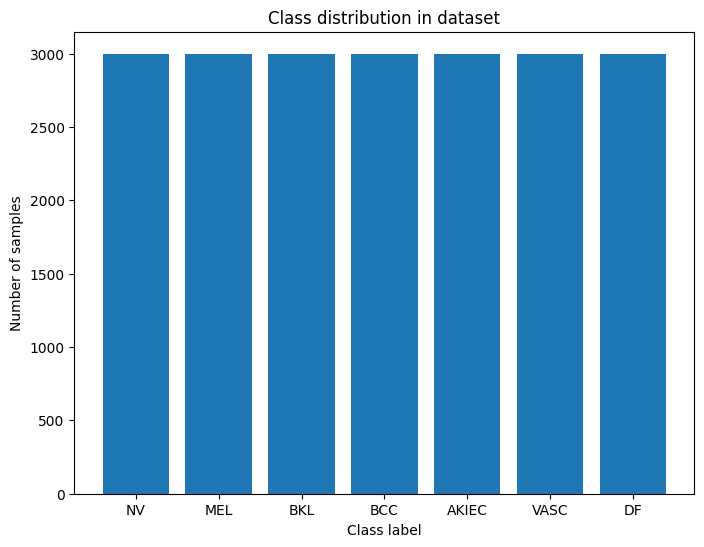

(21000, 15)

In [21]:
# check Class distribution in entire dataset
unique_labels, counts = np.unique(augmented_final['label_idx'], return_counts=True)
plt.figure(figsize=(8, 6))
plt.bar(cols.values(), counts)
plt.xlabel('Class label')
plt.ylabel('Number of samples')
plt.title('Class distribution in dataset')
plt.show()
augmented_final.shape


In [22]:
# Splitting dataset into three for Each Models (ViT, VGG16, Resnet50)
from sklearn.model_selection import train_test_split
vit_data, rest_data = train_test_split(augmented_final, test_size=2/3, random_state=42)
vgg16_data, resnet50_data = train_test_split(rest_data, test_size=0.5,random_state=42)

vit_data.shape, vgg16_data.shape, resnet50_data.shape

((7000, 15), (7000, 15), (7000, 15))

In [23]:
test_vit, test_rest = train_test_split(df3, test_size=1/3, random_state=42)
test_vgg16, test_resnet18 = train_test_split(test_rest, test_size=1/2, random_state=42)


In [24]:
# Splitting all versions into training and validation 80/20 split
train_vit_df, val_vit_df = train_test_split(vit_data, test_size=0.2, random_state=42)
train_vgg16_df, val_vgg16_df = train_test_split(vgg16_data, test_size=0.2, random_state=42)
train_resnet50_df, val_resnet50_df = train_test_split(resnet50_data, test_size=0.2, random_state=42)

In [25]:
# Making the training function
def train_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_func: torch.nn.Module,
              optimizer: torch.optim.Optimizer,
              device: torch.device
              ):

  train_loss = 0
  train_acc = 0

  for batch, (image, label) in enumerate(dataloader):

    image, label = image.to(device), label.to(device)

    pred_label = model(image)

    loss = loss_func(pred_label, label)
    train_loss += loss.item()

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    y_pred_class = torch.argmax(torch.softmax(pred_label, dim=1), dim=1)
    train_acc += (y_pred_class == label).sum().item()/len(pred_label)

  # Adjust metrics to get average loss and accuracy per batch
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc



In [26]:
# Making the validation/inference function

def valid_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_func: torch.nn.Module,
              device: torch.device):

  valid_loss, valid_acc = 0,0

  model.eval()
  with torch.inference_mode():

    for batch, (image, label) in enumerate(dataloader):
      image, label = image.to(device), label.to(device)

      pred_label = model(image)

      loss = loss_func(pred_label, label)
      valid_loss += loss.item()

      valid_pred_labels = pred_label.argmax(dim=1)
      valid_acc += ((valid_pred_labels == label).sum().item()/len(valid_pred_labels))

  valid_loss = valid_loss / len(dataloader)
  valid_acc = valid_acc / len(dataloader)
  return valid_loss, valid_acc



In [27]:
def predict(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              device: torch.device):
    pred = []
    
    actual = []
    test_acc = 0
    model.eval()
    with torch.inference_mode():
        
        for batch, (image, label) in enumerate(dataloader):
            image, label = image.to(device), label.to(device)

            pred_label = model(image)
            test_pred_labels = pred_label.argmax(dim=1)
            test_acc += ((test_pred_labels == label).sum().item()/len(test_pred_labels))

            
            for ans in test_pred_labels:
                
                pred.append(ans.detach().cpu().numpy())
            for ac in label:
                actual.append(ac.detach().cpu().numpy())


    test_acc = test_acc / len(dataloader)

    return pred, actual

In [28]:
# Putting it all together

def train(model: torch.nn.Module,
              train_dataloader: torch.utils.data.DataLoader,
              valid_data_loader: torch.utils.data.DataLoader,
              loss_func: torch.nn.Module,
              optimizer: torch.optim.Optimizer,
              epochs: int,
              device: torch.device):

  train_results = {"train_loss": [],
                 "train_acc": [],
                 "valid_loss": [],
                 "valid_acc": []}
  model.to(device)
  for epoch in range(epochs):

    train_loss, train_acc = train_step(model = model,
                                           dataloader = train_dataloader,
                                           loss_func = loss_func,
                                           optimizer = optimizer,
                                           device = device)

    valid_loss, valid_acc = valid_step(model = model,
                                           dataloader = valid_data_loader,
                                           loss_func = loss_func,
                                           device = device)
    print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"valid_loss: {valid_loss:.4f} | "
          f"valid_acc: {valid_acc:.4f}"
        )
    # Update results dictionary
    train_results["train_loss"].append(train_loss)
    train_results["train_acc"].append(train_acc)
    train_results["valid_loss"].append(valid_loss)
    train_results["valid_acc"].append(valid_acc)

  return train_results

In [29]:
# Move the model to the GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

For the ViT model

In [30]:
import time
# changing the size of the images for the pretrained ViT model hair removal
transform_train_vit = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomCrop(224, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),  (0.229, 0.224, 0.225)),
])

transform_test_vit = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),  (0.229, 0.224, 0.225)),
])

# Create an instance of the custom dataset
dataset_vit = CustomImageDataset(train_vit_df, transform=transform_train_vit)

# Create a data loader
train_loader_vit = DataLoader(dataset_vit, batch_size=32, shuffle=True )

# Create an instance of the custom dataset
val_dataset_vit = CustomImageDataset(val_vit_df, transform = transform_test_vit)

# Create a data loader
val_loader_vit = DataLoader(val_dataset_vit, batch_size=32, shuffle=True)





In [31]:
# Create an instance of the custom dataset
dataset_vgg16 = CustomImageDataset(train_vgg16_df, transform=transform_train_vit)

# Create a data loader
train_loader_vgg16 = DataLoader(dataset_vgg16, batch_size=32, shuffle=True )

# Create an instance of the custom dataset
val_dataset_vgg16 = CustomImageDataset(val_vgg16_df, transform = transform_test_vit)

# Create a data loader
val_loader_vgg16 = DataLoader(val_dataset_vgg16, batch_size=32, shuffle=True)

In [32]:
# Create an instance of the custom dataset
dataset_resnet50 = CustomImageDataset(train_resnet50_df, transform=transform_train_vit)

# Create a data loader
train_loader_resnet50 = DataLoader(dataset_resnet50, batch_size=32, shuffle=True )

# Create an instance of the custom dataset
val_dataset_resnet50 = CustomImageDataset(val_resnet50_df, transform = transform_test_vit)

# Create a data loader
val_loader_resnet50 = DataLoader(val_dataset_resnet50, batch_size=32, shuffle=True)

In [33]:
# Create an instance of the custom dataset
test_dataset_vit_meta = CustomImageDataset(test_vit, transform = transform_test_vit)

# Create a data loader
test_loader_vit_meta = DataLoader(test_dataset_vit_meta, batch_size=32, shuffle=True)

# Create an instance of the custom dataset
test_dataset_vgg16_meta = CustomImageDataset(test_vgg16, transform = transform_test_vit)

# Create a data loader
test_loader_vgg16_meta = DataLoader(test_dataset_vgg16_meta, batch_size=32, shuffle=True)

# Create an instance of the custom dataset
test_dataset_resnet18_meta = CustomImageDataset(test_resnet18, transform = transform_test_vit)

# Create a data loader
test_loader_resnet18_meta = DataLoader(test_dataset_resnet18_meta, batch_size=32, shuffle=True)

In [34]:
# Importing the model
import torchvision
# For the ViT model
from torchvision.utils import make_grid
from torchvision import transforms, datasets

set_seed(42)
# Getting pretrained weights for ViT-Base model
vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT

# Setting up model with pretrained weights
pretrained_vit = torchvision.models.vit_b_16(weights = vit_weights).to(device)

# Freezing the layers
s = 0
for parameters in pretrained_vit.parameters():
  if s < 120:
    parameters.requires_grad = False
  else:
    parameters.requires_grad = True
  s+=1
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(unique_labels)).to(device)

In [35]:
# Adding dense layers for the prediction
pretrained_vit.heads = nn.Sequential(
    nn.Linear(in_features=768, out_features=500),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.2),

    nn.Linear(in_features=500, out_features=350),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.15),
    
    nn.Linear(in_features=350, out_features=95),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.11),

    nn.Linear(in_features=95, out_features=7),

)

In [36]:
# Optimizer and Loss
optimizer_vit = torch.optim.Adam(params = pretrained_vit.parameters(), lr = 9e-4)

# The loss function
loss_func_vit = torch.nn.CrossEntropyLoss()


In [37]:

# Training the ViT Model
set_seed(42)

start = time.time()
vision_results = train(model = pretrained_vit, train_dataloader=train_loader_vit, valid_data_loader=val_loader_vit,
                       optimizer = optimizer_vit, loss_func = loss_func_vit, epochs = 20, device = device)
end = time.time()
vision_time = (end-start)/60
print(vision_time, 'minutes')


Epoch: 1 | train_loss: 1.2901 | train_acc: 0.4927 | valid_loss: 1.0394 | valid_acc: 0.6082
Epoch: 2 | train_loss: 0.8331 | train_acc: 0.6723 | valid_loss: 0.7294 | valid_acc: 0.7178
Epoch: 3 | train_loss: 0.7008 | train_acc: 0.7277 | valid_loss: 0.7560 | valid_acc: 0.7282
Epoch: 4 | train_loss: 0.5517 | train_acc: 0.7936 | valid_loss: 0.6810 | valid_acc: 0.7609
Epoch: 5 | train_loss: 0.5106 | train_acc: 0.8123 | valid_loss: 0.6149 | valid_acc: 0.7831
Epoch: 6 | train_loss: 0.4591 | train_acc: 0.8250 | valid_loss: 0.5676 | valid_acc: 0.7945
Epoch: 7 | train_loss: 0.3940 | train_acc: 0.8518 | valid_loss: 0.5338 | valid_acc: 0.7938
Epoch: 8 | train_loss: 0.3442 | train_acc: 0.8736 | valid_loss: 0.4361 | valid_acc: 0.8445
Epoch: 9 | train_loss: 0.3300 | train_acc: 0.8773 | valid_loss: 0.3904 | valid_acc: 0.8551
Epoch: 10 | train_loss: 0.2627 | train_acc: 0.9105 | valid_loss: 0.4088 | valid_acc: 0.8696
Epoch: 11 | train_loss: 0.2787 | train_acc: 0.9002 | valid_loss: 0.3578 | valid_acc: 0.86

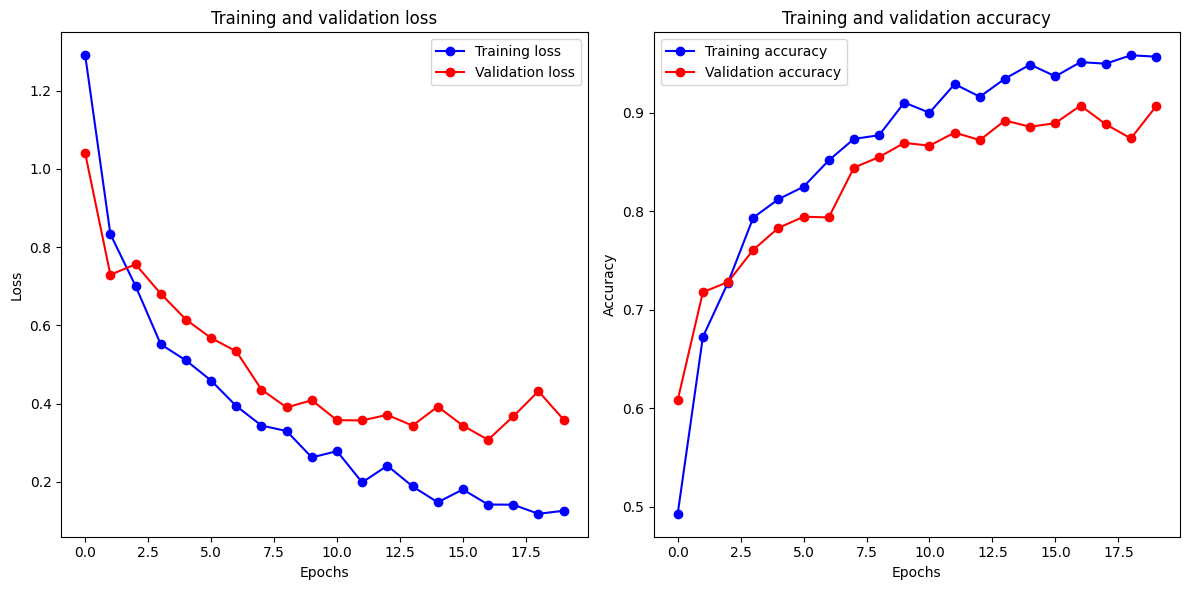

In [38]:

plt.figure(figsize=(12, 6))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(vision_results['train_loss'], 'bo-', label='Training loss')
plt.plot(vision_results['valid_loss'], 'ro-', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('Vit Loss')

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(vision_results['train_acc'], 'bo-', label='Training accuracy')
plt.plot(vision_results['valid_acc'], 'ro-', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('ViT accuracy')

plt.tight_layout()
plt.show()

In [39]:
# Saving model
torch.save(pretrained_vit.state_dict(), f'vit_final{generate_random_code(3)}.pth')


For the VGG16 Model

In [40]:
set_seed(42)
model_vgg16 = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)

# Freeze all the parameters in the feature extraction layers
for param in model_vgg16.parameters():
    param.requires_grad = False

model_vgg16.avgpool = nn.AdaptiveAvgPool2d(output_size=(2, 2))
# Reconstruct the classifier with new layers
# Since the output of avgpool is [batch_size, 512, 2, 2], we have 512 * 2 * 2 = 2048 features
model_vgg16.classifier = nn.Sequential(
    nn.Linear(in_features=2048, out_features=1024),  # First linear layer
    nn.ReLU(inplace=True),  # Activation function
    nn.Dropout(p=0.2),  # Dropout to prevent overfitting
    nn.Linear(in_features=1024, out_features=512),  # Second linear layer
    nn.ReLU(inplace=True),  # Activation function
    nn.Dropout(p=0.1),  # Dropout to prevent overfitting
    nn.Linear(in_features=512, out_features=7)  # Final layer for 7 output classes
)

In [41]:
model_vgg16 = model_vgg16.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_vgg16.parameters(), lr=1e-4)

In [42]:
start = time.time()
vgg16_results = train(model = model_vgg16, train_dataloader=train_loader_vgg16, valid_data_loader=val_loader_vgg16,
                       optimizer = optimizer, loss_func = criterion, epochs = 20, device = device)
end = time.time()
vgg16_time = (end-start)/60
print(vgg16_time, 'minutes')

Epoch: 1 | train_loss: 1.5383 | train_acc: 0.4407 | valid_loss: 1.1820 | valid_acc: 0.5630
Epoch: 2 | train_loss: 1.0681 | train_acc: 0.6111 | valid_loss: 0.9848 | valid_acc: 0.6366
Epoch: 3 | train_loss: 0.9017 | train_acc: 0.6687 | valid_loss: 0.8971 | valid_acc: 0.6695
Epoch: 4 | train_loss: 0.8000 | train_acc: 0.7093 | valid_loss: 0.8214 | valid_acc: 0.6984
Epoch: 5 | train_loss: 0.7380 | train_acc: 0.7304 | valid_loss: 0.7779 | valid_acc: 0.7280
Epoch: 6 | train_loss: 0.6793 | train_acc: 0.7502 | valid_loss: 0.7341 | valid_acc: 0.7344
Epoch: 7 | train_loss: 0.6210 | train_acc: 0.7755 | valid_loss: 0.7423 | valid_acc: 0.7270
Epoch: 8 | train_loss: 0.5899 | train_acc: 0.7891 | valid_loss: 0.7408 | valid_acc: 0.7202
Epoch: 9 | train_loss: 0.5480 | train_acc: 0.7993 | valid_loss: 0.6869 | valid_acc: 0.7505
Epoch: 10 | train_loss: 0.5233 | train_acc: 0.8075 | valid_loss: 0.6808 | valid_acc: 0.7500
Epoch: 11 | train_loss: 0.4799 | train_acc: 0.8271 | valid_loss: 0.6496 | valid_acc: 0.76

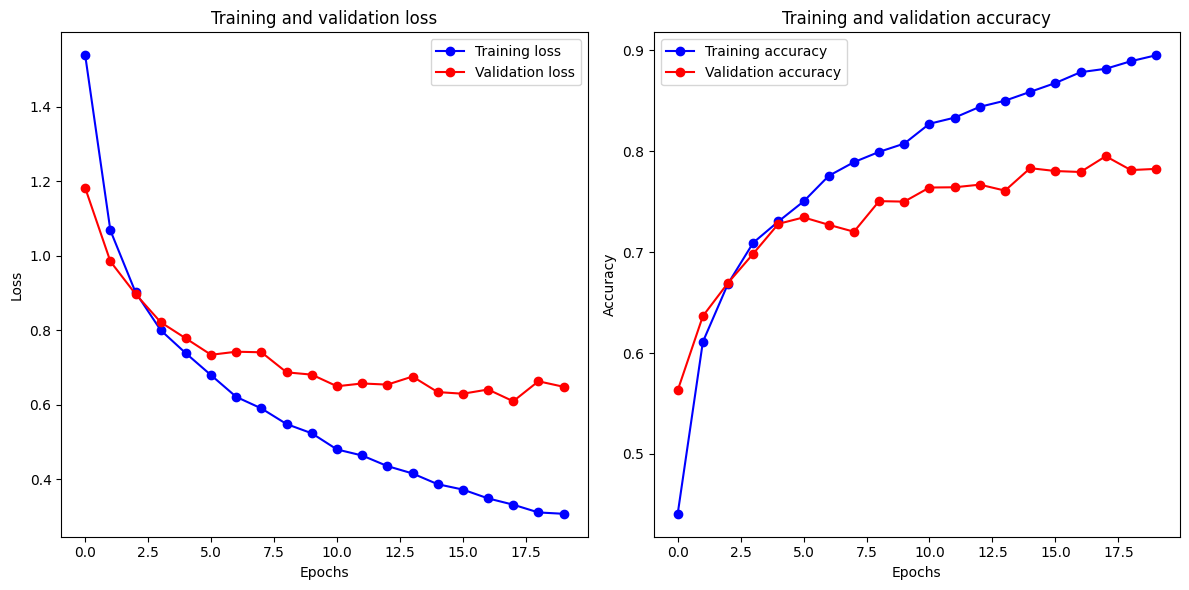

In [43]:
# Plot training and validation loss
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(vgg16_results['train_loss'], 'bo-', label='Training loss')
plt.plot(vgg16_results['valid_loss'], 'ro-', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('VGG16 Loss')

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(vgg16_results['train_acc'], 'bo-', label='Training accuracy')
plt.plot(vgg16_results['valid_acc'], 'ro-', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('VGG16 accuracy')

plt.tight_layout()
plt.show()

In [44]:
# Saving model
torch.save(model_vgg16.state_dict(), f'vgg16_final{generate_random_code(3)}.pth')

For Resnet50 Model

In [45]:

set_seed(42)
model_resnet50 = models.resnet18(pretrained=True)
# # Freeze the layers of the ResNet18 model
for param in model_resnet50.parameters():
    param.requires_grad = False

# Modify the last layer of the model
num_classes = 7 # replace with the number of classes in your dataset
num_features = model_resnet50.fc.in_features
# Replace the model's classifier
model_resnet50.fc = nn.Sequential(
    nn.Linear(in_features=num_features, out_features=200),  # Use the correct in_features
    nn.ReLU(),
    nn.Dropout(0.15),
    nn.Linear(200, num_classes)
)

/home/teb344/miniconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/teb344/miniconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [46]:
model_resnet50 = model_resnet50.to(device)
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_resnet50.parameters(), lr=0.0009)

In [47]:
start = time.time()
resnet50_results = train(model = model_resnet50, train_dataloader=train_loader_vgg16, valid_data_loader=val_loader_vgg16,
                       optimizer = optimizer, loss_func = criterion, epochs = 25, device = device)
end = time.time()
resnet50_time = (end-start)/60
resnet50_time = np.round(resnet50_time, 3)
print(resnet50_time, 'minutes')

Epoch: 1 | train_loss: 1.3214 | train_acc: 0.5021 | valid_loss: 1.0751 | valid_acc: 0.6020
Epoch: 2 | train_loss: 0.9499 | train_acc: 0.6429 | valid_loss: 0.9756 | valid_acc: 0.6229
Epoch: 3 | train_loss: 0.8603 | train_acc: 0.6768 | valid_loss: 0.8849 | valid_acc: 0.6629
Epoch: 4 | train_loss: 0.8201 | train_acc: 0.6979 | valid_loss: 0.8462 | valid_acc: 0.6728
Epoch: 5 | train_loss: 0.7742 | train_acc: 0.7070 | valid_loss: 0.8370 | valid_acc: 0.6740
Epoch: 6 | train_loss: 0.7360 | train_acc: 0.7204 | valid_loss: 0.8115 | valid_acc: 0.6823
Epoch: 7 | train_loss: 0.6893 | train_acc: 0.7389 | valid_loss: 0.7867 | valid_acc: 0.6889
Epoch: 8 | train_loss: 0.6688 | train_acc: 0.7523 | valid_loss: 0.7457 | valid_acc: 0.7133
Epoch: 9 | train_loss: 0.6440 | train_acc: 0.7550 | valid_loss: 0.7600 | valid_acc: 0.7159
Epoch: 10 | train_loss: 0.6200 | train_acc: 0.7718 | valid_loss: 0.7772 | valid_acc: 0.7022
Epoch: 11 | train_loss: 0.6078 | train_acc: 0.7684 | valid_loss: 0.7266 | valid_acc: 0.72

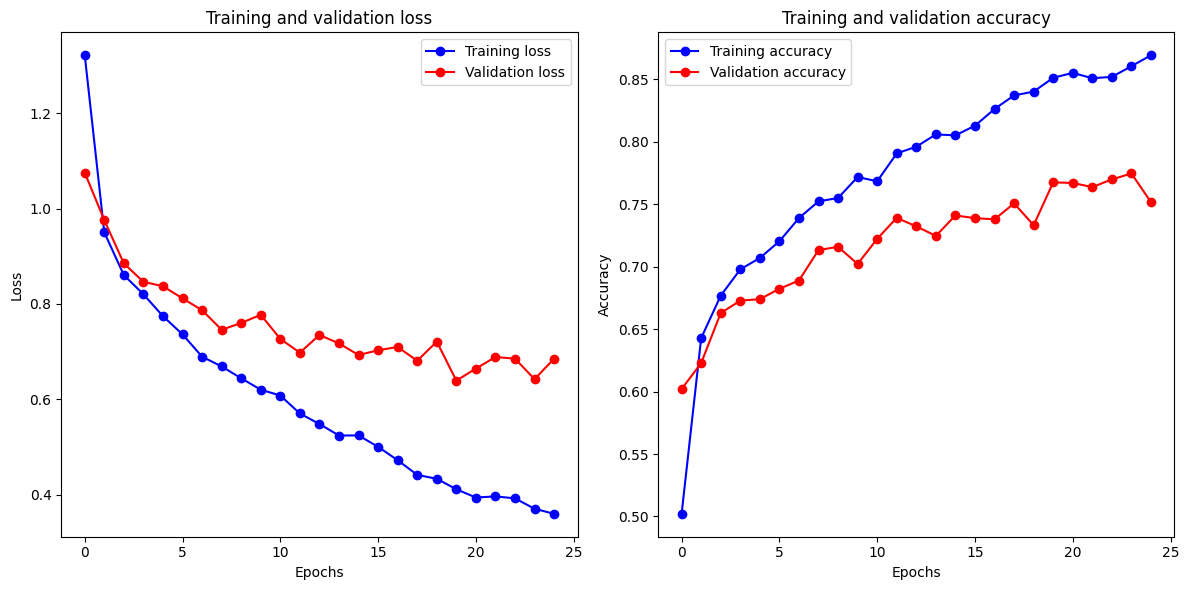

In [48]:
plt.figure(figsize=(12, 6))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(resnet50_results['train_loss'], 'bo-', label='Training loss')
plt.plot(resnet50_results['valid_loss'], 'ro-', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('Resnet18 Loss')

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(resnet50_results['train_acc'], 'bo-', label='Training accuracy')
plt.plot(resnet50_results['valid_acc'], 'ro-', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('Resnet18 accuracy')

plt.tight_layout()
plt.show()

In [49]:
# Saving model
torch.save(pretrained_vit.state_dict(), f'resnet_final{generate_random_code(3)}.pth')


Creating Meta training and Validation Data

In [50]:
# Taking the proberbility of each 7 class as features into the meta learner 
def meta_features(model, device, data_loader):

        nn_output = []
        actual = []
        model.eval()
        with torch.inference_mode():
                
                for batch, (img, label) in enumerate(data_loader):
                        img, label = img.to(device), label.to(device)
                        out = model(img)

                        for lab in label:
                                actual.append(lab.detach().cpu().numpy())
                                
                        for i in out: 
                                nn_output.append(i.detach().cpu().numpy())

        features = pd.DataFrame(nn_output, columns=['One', 'Two', 'Three', 'Four', 'Five', 'Six', 'Seven'])   
        features['Actual'] = actual

        return features 


In [51]:
model_list = [pretrained_vit, model_vgg16, model_resnet50]
train_list =[train_loader_vit, train_loader_vgg16, train_loader_resnet50]
val_list = [val_loader_vit, val_loader_vgg16, val_loader_resnet50]
test_list = [test_loader_vit_meta, test_loader_vgg16_meta, test_loader_resnet18_meta]

meta_train_data = []
meta_val_data = []
meta_test_data = []

# Meta Training Data
for i, (model) in enumerate(model_list):
    meta_train_data.append(meta_features(model, device, train_list[i]))

# Meta Validation Data
for i, (model) in enumerate(model_list):
    meta_val_data.append(meta_features(model, device, val_list[i]))

# Meta Testing Data
for i, (model) in enumerate(model_list):
    meta_test_data.append(meta_features(model, device, test_list[i]))

In [52]:
meta_train = pd.concat([meta_train_data[0], meta_train_data[1], meta_train_data[2]])
meta_val = pd.concat([meta_val_data[0], meta_val_data[1], meta_val_data[2]])
meta_test = pd.concat([meta_test_data[0], meta_test_data[1], meta_test_data[2]])

In [53]:
meta_train_target = meta_train['Actual']
meta_val_target = meta_val['Actual']
meta_test_target = meta_test['Actual']

meta_train = meta_train.drop(columns='Actual', axis=1)
meta_val = meta_val.drop(columns='Actual', axis=1)
meta_test = meta_test.drop(columns='Actual', axis=1)

meta_train.shape, meta_val.shape, meta_test.shape

((16800, 7), (4200, 7), (1512, 7))

In [54]:
# Loading testing data 
test_dataset_vit = CustomImageDataset(df3, transform=transform_test_vit)
test_loader_vit = DataLoader(test_dataset_vit, shuffle=True, batch_size=32)

In [55]:
predictions_vit, actual_vit = predict(pretrained_vit, test_loader_vit, device=device)
predictions_vgg16, actual_vgg16 = predict(model_vgg16, test_loader_vit, device=device)
predictions_resnet50, actual_resnet50= predict(model_resnet50, test_loader_vit, device=device)


In [56]:
from sklearn.preprocessing import LabelBinarizer

def binary(actual, predicted):

    # Assuming 'pred' is your predictions array
    label_binarizer = LabelBinarizer()
    label_binarizer.fit(range(len(predicted)))
    pred_one_hot = label_binarizer.transform(predicted)
    actual_one_hot = label_binarizer.transform(actual)
    return actual_one_hot, pred_one_hot

In [198]:
key_arr = np.array(cols.keys())
print(key_arr)
key_arr = np.array([1,0,4,2,3,6,5])
key_values = ['NV', 'MEL', 'BKL', 'BCC', 'AKIEC', 'VASC', 'DF']

#  Classification Metrics
def compute_performance_multi_class_weighted(yhat, y, classes, names, model_name):
    metrics = {
        'accuracy': [],
        'balanced_accuracy': [],
        'precision': [],
        'recall': [],  # Sensitivity
        'specificity': [],
        'f1_score': [],
        'support': []  # Number of instances for each class
    }
    
    total_instances = len(y)
    x = 0
    print(f"\nFor the {model_name} model")
    
    for current_class in classes:
        tp = sum((yhat == current_class) & (y == current_class))
        tn = sum((yhat != current_class) & (y != current_class))
        fp = sum((yhat == current_class) & (y != current_class))
        fn = sum((yhat != current_class) & (y == current_class))
        
        acc = (tp + tn) / (tp + tn + fp + fn)
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0  # Sensitivity
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        balanced_acc = (recall + specificity) / 2
        support = sum(y == current_class)
        
        # Append the metrics for the current class
        metrics['accuracy'].append(acc)
        metrics['balanced_accuracy'].append(balanced_acc)
        metrics['precision'].append(precision)
        metrics['recall'].append(recall)
        metrics['specificity'].append(specificity)
        metrics['f1_score'].append(f1)
        metrics['support'].append(support)
        
        
        print(f"Class: {names[x]}, Support: {support}, TP: {tp}, TN: {tn}, FP: {fp}, FN: {fn}, "
              f"Acc: {acc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, "
              f"Specificity: {specificity:.4f}, F1: {f1:.4f}, Balanced Acc: {balanced_acc:.4f}")
        x+=1

    # Calculate and print weighted average of the metrics
    print("\nWeighted-Average Metrics:")
    for metric_name in ['accuracy', 'balanced_accuracy', 'precision', 'recall', 'specificity', 'f1_score']:
        weighted_average = np.average(metrics[metric_name], weights=metrics['support'])
        print(f"{metric_name.capitalize()}: {weighted_average:.4f}")

dict_keys([1, 0, 4, 2, 3, 6, 5])


In [ ]:
# # Scorings 
# from sklearn.metrics import classification_report, confusion_matrix

# def scores(actual, predictions, model_type):
#     # actual_roc, pred_roc = binary(actual, predictions)
#     results = {
#         "Balanced_Acc": [balanced_accuracy_score(actual, predictions)],
#                     "Acc": [accuracy_score(actual, predictions)],
#                     "F1_score": [f1_score(actual, predictions, average='weighted')],
#                     # "roc_auc_score": [roc_auc_score(actual_roc, pred_roc, multi_class='ovr', average='micro')]
#                     }

#     print(F"For the {model_type} model the results are: \n")
#     print(classification_report(actual, predictions, target_names=cols.values()))
#     print(f"Balanced Accuracy is: {results['Balanced_Acc']}")
#     print(f"Accuracy is: {results['Acc']}")
#     print(f"F1 Score is: {results['F1_score']}")
#     # print(f"ROC AUC Score is: {results['roc_auc_score']}\n")
#     return results



In [65]:
from sklearn.model_selection import GridSearchCV
params = {
    'max_depth': [2,3,5,6],
    'n_estimators': [100, 200, 350],
    'eta': [1e02, 2e-3, 1e-4],
    'gamma': [0.1, 0.5, 0.8]
}

In [ ]:
from sklearn.ensemble import RandomForestClassifier
param_grid = {
    "n_estimators": [400, 600, 800],
    "max_depth": [None, 2, 4, 6],
    "min_samples_leaf": [1, 2, 3]
}

meta_randomF = RandomForestClassifier(random_state=42, oob_score=True, bootstrap=True)
grid_search_rf_meta = GridSearchCV(estimator=meta_randomF,
                                   param_grid=param_grid, cv=5, scoring='neg_log_loss', n_jobs=-1 ,
                                   refit=True, error_score='raise').fit(meta_train, meta_train_target)

print(f"The best hyperparameters are: {grid_search_rf_meta.best_params_}")

In [172]:
pred_rf= np.array(grid_search_rf_meta.predict(meta_test).astype(int))
actual = meta_test_target.values


In [184]:
#  Classification Metrics
def compute_performance_multi_class_weighted(yhat, y, classes, names, model_name):
    metrics = {
        'accuracy': [],
        'balanced_accuracy': [],
        'precision': [],
        'recall': [],  # Sensitivity
        'specificity': [],
        'f1_score': [],
        'support': []  # Number of instances for each class
    }
    
    total_instances = len(y)
    x = 0
    
    for current_class in classes:
        tp = sum((yhat == current_class) & (y == current_class))
        tn = sum((yhat != current_class) & (y != current_class))
        fp = sum((yhat == current_class) & (y != current_class))
        fn = sum((yhat != current_class) & (y == current_class))
        
        acc = (tp + tn) / (tp + tn + fp + fn)
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0  # Sensitivity
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        balanced_acc = (recall + specificity) / 2
        support = sum(y == current_class)
        
        # Append the metrics for the current class
        metrics['accuracy'].append(acc)
        metrics['balanced_accuracy'].append(balanced_acc)
        metrics['precision'].append(precision)
        metrics['recall'].append(recall)
        metrics['specificity'].append(specificity)
        metrics['f1_score'].append(f1)
        metrics['support'].append(support)
        
        print(f"Class: {names[x]}, Support: {support}, TP: {tp}, TN: {tn}, FP: {fp}, FN: {fn}, "
              f"Acc: {acc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, "
              f"Specificity: {specificity:.4f}, F1: {f1:.4f}, Balanced Acc: {balanced_acc:.4f}")
        x+=1

    # Calculate and print weighted average of the metrics
    print("\nWeighted-Average Metrics:")
    for metric_name in ['accuracy', 'balanced_accuracy', 'precision', 'recall', 'specificity', 'f1_score']:
        weighted_average = np.average(metrics[metric_name], weights=metrics['support'])
        print(f"{metric_name.capitalize()}: {weighted_average:.4f}")

In [201]:
vit_results = compute_performance_multi_class_weighted(predictions_vit, actual_vit, key_arr, key_values, "ViT")
vgg16_results = compute_performance_multi_class_weighted(predictions_vgg16, actual_vgg16, key_arr, key_values, "VGG16")
resnet50_results = compute_performance_multi_class_weighted(predictions_resnet50, actual_resnet50, key_arr, key_values, "Resnet18")
meta_results = compute_performance_multi_class_weighted(pred_rf, actual, key_arr, key_values, "Meta_Learner")


For the ViT model
Class: NV, Support: 909, TP: 711, TN: 555, FP: 48, FN: 198, Acc: 0.8373, Precision: 0.9368, Recall: 0.7822, Specificity: 0.9204, F1: 0.8525, Balanced Acc: 0.8513
Class: MEL, Support: 171, TP: 89, TN: 1256, FP: 85, FN: 82, Acc: 0.8896, Precision: 0.5115, Recall: 0.5205, Specificity: 0.9366, F1: 0.5159, Balanced Acc: 0.7285
Class: BKL, Support: 217, TP: 160, TN: 1111, FP: 184, FN: 57, Acc: 0.8406, Precision: 0.4651, Recall: 0.7373, Specificity: 0.8579, F1: 0.5704, Balanced Acc: 0.7976
Class: BCC, Support: 93, TP: 71, TN: 1347, FP: 72, FN: 22, Acc: 0.9378, Precision: 0.4965, Recall: 0.7634, Specificity: 0.9493, F1: 0.6017, Balanced Acc: 0.8564
Class: AKIEC, Support: 43, TP: 24, TN: 1458, FP: 11, FN: 19, Acc: 0.9802, Precision: 0.6857, Recall: 0.5581, Specificity: 0.9925, F1: 0.6154, Balanced Acc: 0.7753
Class: VASC, Support: 35, TP: 21, TN: 1475, FP: 2, FN: 14, Acc: 0.9894, Precision: 0.9130, Recall: 0.6000, Specificity: 0.9986, F1: 0.7241, Balanced Acc: 0.7993
Class: D